In [2]:
import numpy as np
import matplotlib.pyplot as plt

# SAMPLES

In [135]:
def plot_distribution(samples, probability_fn, density_fn, title, *fn_args):

    f, ax = plt.subplots(1, 2)
    f.suptitle(title)

    ax[0].set_title("Probability")
    ax[0].plot(samples, probability_fn(samples, *fn_args))

    ax[1].set_title("Density")
    ax[1].plot(samples, density_fn(samples, *fn_args))

In [150]:
size = 100
scale = 1
exponential_samples = np.array(sorted(np.random.exponential(scale, size)))

def exponential_density(data, scale):
    zero_mask = data <= 0
    result = scale*(np.exp(-scale*data))
    result[zero_mask] = 0
    return result

def exponential_probability(data, scale):
    
    zero_mask = data <= 0 
    result = 1 - np.exp(-scale*data)
    result[zero_mask] = 0
    return result


In [138]:
a, b = 0, 1
uniform_samples = np.array(sorted(np.random.uniform(a, b, size)))

def uniform_density(data, a, b):
    zero_mask = np.logical_or(data < a, data > b) 
        
    result = np.full(data.shape, 1/(b-a))
    result[zero_mask] = 0
    return result


def uniform_probability(data, a, b):
    
    zero_mask = data < a
    ones_mask = data > b 
        
    result = (data - a)/(b-a)
    result[zero_mask] = 0
    result[ones_mask] = 1
    return result

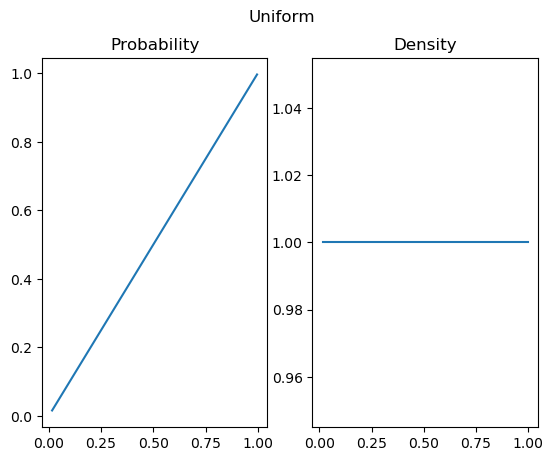

In [139]:
plot_distribution(uniform_samples, uniform_probability, uniform_density, "Uniform", a, b)

# Rejection sampling

Use proposal function to generate additional samples that distribution density looks like original samples

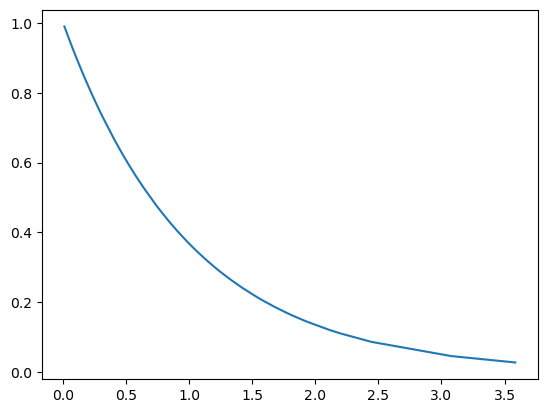

In [45]:
# samples from lab 5

plt.plot(exponential_samples, exponential_density(exponential_samples, scale))

## Find coefficient C so that original function values would be inside proposal function 

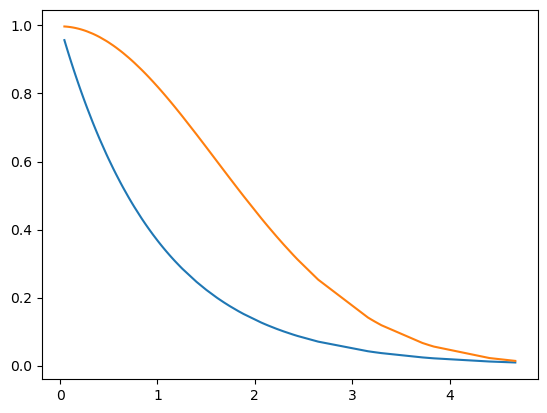

In [25]:
def normal_pdf(data, mean, std):
    return np.exp(-0.5*((data - mean)/std)**2)/(2*np.pi*std**2)**0.5

plt.plot(exponential_samples, exponential_density(exponential_samples, scale))
plt.plot(exponential_samples, normal_pdf(exponential_samples, 0, 1.6)*4)

## Sample points for exponential pdf

In [71]:
def rejection_sample(proposal_function, original_function, size, scale, mean, std, C):

     accepted_samples = np.array([])
     while len(accepted_samples) < size:
          U = np.random.uniform(0, 1, size)
          samples = np.random.normal(mean, std, size)
          mask =np.logical_and(original_function(samples, scale)/(proposal_function(samples, mean,std)*C) > U, samples>0)
          accepted_samples = np.append(accepted_samples, samples[mask])

     return accepted_samples

In [76]:
new_samples = rejection_sample(normal_pdf, exponential_density, 30,  1, 0, 1.6, 4)

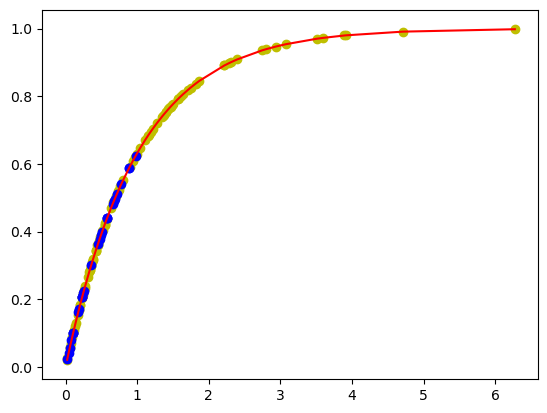

In [172]:
plt.scatter(exponential_samples, exponential_probability(exponential_samples, scale), color="y")
plt.plot(exponential_samples, exponential_probability(exponential_samples, scale), color="r")
plt.scatter(new_samples, exponential_probability(new_samples, scale), color="b")


## Sample points for uniform pdf

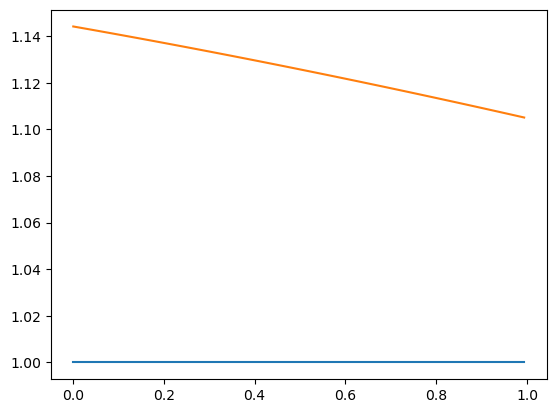

In [133]:
def normal_pdf(data, mean, std):
    return np.exp(-0.5*((data - mean)/std)**2)/(2*np.pi*std**2)**0.5

plt.plot(uniform_samples, uniform_density(uniform_samples, a= 0, b=1))
plt.plot(uniform_samples, normal_pdf(uniform_samples, -3, 10)*30)

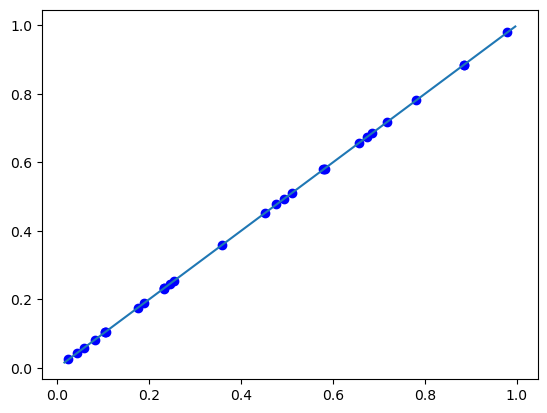

In [166]:
def rejection_sample(proposal_function, original_function, size, a, b, mean, std, C):

     accepted_samples = np.array([])
     while len(accepted_samples) < size:
          U = np.random.uniform(0, 1, size)
          samples = np.random.normal(mean, std, size)
          mask = original_function(samples, a, b)/(proposal_function(samples, mean,std)*C) > U
          accepted_samples = np.append(accepted_samples, samples[mask])

     return accepted_samples
new_samples = rejection_sample(normal_pdf, uniform_density, 30,  0, 1,-3, 10,30)


plt.plot(uniform_samples, uniform_probability(uniform_samples, a= 0, b=1))
plt.scatter(new_samples, uniform_probability(new_samples, 0, 1), color="b")

# Metropolis-Gastings 

generate yt dependent on some variable xt-1 from original distribution using proposed sampler

calculate probability of new y by calculating Pt = min(f(yt)*q(xt-1|yt)/f(xt-1)q(yt|xt-1), 1)

take acceptance variable ut from uniform distribution U(0, 1)

if ut <= Pt: accept and xt = yt

repeat until required number of samples would not be accumulated

In [173]:
def Metropolis_Gastings_exponential(original_density, sampling_density, size, xt):

    accepted_samples = np.array([])

    while len(accepted_samples)<size:

        yt = sampling_density(loc = xt).reshape(-1, 1)
        pt = min(
            (original_density(data = yt))/(original_density(data = xt)),
            # (original_density(data = yt)*sampling_density(loc = yt))/(original_density(data = xt)*sampling_density(loc = xt)), 
            1)

        u = np.random.uniform(0, 1, 1)

        if pt > u:
            accepted_samples = np.append(accepted_samples, yt)
            xt = yt

    return accepted_samples

    
def curry_args(func, **kwargs):
    def args_inserter(**seckwargs):
        return func(**seckwargs, **kwargs)
    return args_inserter

In [151]:

curried_norm = curry_args(np.random.normal, size=1, scale = 1.6)
curried_expon = curry_args(exponential_density, scale=1)

In [174]:
exp_mg_samples = Metropolis_Gastings_exponential(curried_expon, curried_norm, size=30, xt=exponential_samples[3].reshape(-1, 1))

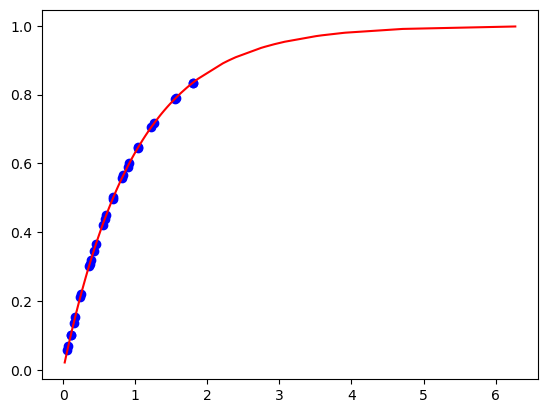

In [175]:
plt.plot(exponential_samples, exponential_probability(exponential_samples, scale), color="r")
plt.scatter(exp_mg_samples, exponential_probability(exp_mg_samples, scale), color="b")

In [161]:
curried_uniform = curry_args(uniform_density, a=0, b=1)

In [178]:
uniform_mg_samples = Metropolis_Gastings_exponential(curried_uniform, curried_norm, size=30, xt=uniform_samples[3].reshape(-1, 1))

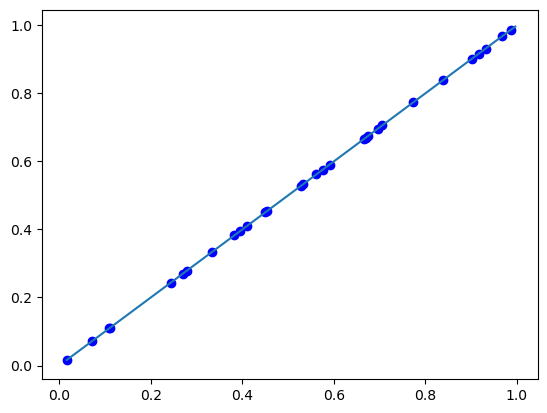

In [179]:
plt.plot(uniform_samples, uniform_probability(uniform_samples, a= 0, b=1))
plt.scatter(uniform_mg_samples, uniform_probability(uniform_mg_samples, 0, 1), color="b")